Реализовать с помощью `Numpy` класс `MyMLP`, моделирующий работу полносвязной нейронной сети.

Реализуемый класс должен

1. Поддерживать создание любого числа слоев с любым числом нейронов. Тип инициализации весов не регламентируется.
2. Обеспечивать выбор следующих функции активации в рамках каждого слоя: `ReLU`, `sigmoid`, `linear`.
3. Поддерживать решение задачи классификации и регрессии (выбор соответствующего лосса, в том числе для задачи многоклассовой классификации).
4. В процессе обучения использовать самостоятельно реализованный механизм обратного распространения (вывод формул в формате markdown) для применения градиентного и стохастического градиентного спусков (с выбором размера батча)
5. Поддерживать использование `l1`, `l2` и `l1l2` регуляризаций.

Самостоятельно выбрать наборы данных (классификация и регрессия). Провести эксперименты (различные конфигурации сети: количество слоев, нейронов, функции активации, скорость обучения и тп. — минимум 5 различных конфигураций) и сравнить результаты работы (оценка качества модели + время обучения и инференса) реализованного класса `MyMLP` со следующими моделям (в одинаковых конфигурациях):

*   MLPClassifier/MLPRegressor из sklearn
*   TensorFlow
*   Keras
*   PyTorch

Результат представить в виде .ipynb блокнота, содержащего весь необходимый код и визуализации сравнения реализаций для рассмотренных конфигураций.

# Библиотеки

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

Производные функций активации

Производная функции активации **сигмоида**:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

$$
\sigma'(x) = - ( - \frac{e^{-x}}{(1 + e^{-x})^2})
$$

$$
\sigma'(x) = \frac{e^{-x}}{(1 + e^{-x})} * \frac{1}{(1 + e^{-x})}
$$

$$
\sigma'(x) =  \frac{1}{(1 + e^{-x})} * (1 - \frac{1}{(1 + e^{-x})})
$$

$$
\sigma'(x) = \sigma(x)(1 - \sigma(x))
$$


Функция активации **ReLU**

$$
\text{ReLU}(x) =
\begin{cases}
x, & \text{если } x \geq 0 \\
0, & \text{если } x < 0 \\
\end{cases}
$$

$$
\text{ReLU}'(x) =
\begin{cases}
1, & \text{если } x \geq 0 \\
0, & \text{если } x < 0 \\
\end{cases}
$$


Функция **tanh**:  

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

Через производную сложной функции  

$$
f'(x) = \frac{u'(x)v(x) - u(x)v'(x)}{[v(x)]^2}
$$

$$
\tanh'(x) = \frac{(e^x + e^{-x})(e^x + e^{-x}) - (e^x - e^{-x})(e^x - e^{-x})}{(e^x + e^{-x})^2}
$$

Числитель по слагаемым:  


$$
(e^x + e^{-x})(e^x + e^{-x}) = (e^x + e^{-x})^2
$$

$$
(e^x - e^{-x})(e^x - e^{-x}) = (e^x - e^{-x})^2
$$


Чилситель:

$$
(e^x + e^{-x})^2 - (e^x - e^{-x})^2
$$

Упростим разность квадратов  

$$
(e^x + e^{-x})^2 - (e^x - e^{-x})^2 = 4e^x \cdot e^{-x} = 4
$$



$$
\tanh'(x) = \frac{4}{(e^x + e^{-x})^2}
$$


$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
\quad \Rightarrow \quad
\tanh^2(x) = \left(\frac{e^x - e^{-x}}{e^x + e^{-x}}\right)^2
$$


Также заметим:

$$
1 - \tanh^2(x) = 1 - \frac{(e^x - e^{-x})^2}{(e^x + e^{-x})^2} = \frac{(e^x + e^{-x})^2 - (e^x - e^{-x})^2}{(e^x + e^{-x})^2} = \frac{4}{(e^x + e^{-x})^2}
$$

То есть:

$$
\tanh'(x) = 1 - \tanh^2(x)
$$

Функция **SoftMAX** уникальный случай с производной по сложному условию (систем уравнений).  
Так как softmax используется для задач многоклассовой классификации, то логично найти её производную по цепочному правилу  
совместно с кросс - энтропией

$$
L = -\sum_{i=1}^n y_i \log(\hat{y}_i)
$$

$$
\frac{\partial L}{\partial \hat{y}_i} = -\frac{y_i}{\hat{y}_i}
$$


$$
\frac{\partial \hat{y}_i}{\partial z_j} =
\begin{cases}
\hat{y}_i(1 - \hat{y}_i), & i = j \\
-\hat{y}_i \hat{y}_j, & i \ne j
\end{cases}
$$

По правилу дифференцирования сложной функции:

$$
\frac{\partial L}{\partial z_j} = \sum_{i=1}^n \frac{\partial L}{\partial \hat{y}_i} \cdot \frac{\partial \hat{y}_i}{\partial z_j}
$$

$$
\frac{\partial L}{\partial z_j} = \sum_{i=1}^n \left(-\frac{y_i}{\hat{y}_i}\right) \cdot \frac{\partial \hat{y}_i}{\partial z_j}
$$

Рассмотрим $ \frac{\partial L}{\partial z_j} $:

$$
\frac{\partial L}{\partial z_j} =
\left(-\frac{y_j}{\hat{y}_j}\right) \cdot \hat{y}_j(1 - \hat{y}_j)
+ \sum_{\substack{i=1 \\ i \ne j}}^n \left(-\frac{y_i}{\hat{y}_i}\right) \cdot (-\hat{y}_i \hat{y}_j)
$$

Упрощаем:

$$
\frac{\partial L}{\partial z_j} = -y_j(1 - \hat{y}_j) + \sum_{\substack{i=1 \\ i \ne j}}^n y_i \hat{y}_j
$$

$$
\frac{\partial L}{\partial z_j} = -y_j + y_j \hat{y}_j + \hat{y}_j \sum_{\substack{i=1 \\ i \ne j}}^n y_i
$$

Так как  $(y_i)$ и $(y_j)$ представляет собой вероятности возникновения этих событий (что метка класса есть этот класс), то  
их сумма = 1

$$
\frac{\partial L}{\partial z_j} = -y_j + \hat{y}_j \cdot 1 = \hat{y}_j - y_j
$$

# MyMLP

In [ ]:
# activation_funcs = {
#     'relu': (lambda Z: np.maximum(0, Z),
#              lambda Z: (Z > 0).astype(float)),

#     'sigmoid': (lambda Z: 1 / (1 + np.exp(-Z)),
#                 lambda Z: (1 / (1 + np.exp(-Z))) * (1 - (1 / (1 + np.exp(-Z))))),

#     'tanh': (lambda Z: np.tanh(Z),
#              lambda Z: 1 - np.tanh(Z)**2),

#     'linear': (lambda x: x,
#                lambda x: 1),

#     'softmax': (lambda Z: np.exp(Z - np.max(Z, axis=0, keepdims=True)) /
#                 np.sum(np.exp(Z - np.max(Z, axis=0, keepdims=True)), axis=0, keepdims=True),
#                 None)
# }

In [ ]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    s = sigmoid(Z)
    return s * (1 - s)

def tanh(Z):
    return np.tanh(Z)

def tanh_derivative(Z):
    return 1 - np.tanh(Z)**2

def softmax(Z):
    e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return e_Z / np.sum(e_Z, axis=0, keepdims=True)

activation_funcs = {
    'relu': (relu, relu_derivative),
    'sigmoid': (sigmoid, sigmoid_derivative),
    'tanh': (tanh, tanh_derivative),
    'linear': (lambda x: x, lambda x: 1),
    'softmax': (softmax, None)  # производная для softmax + кросс-энтропии обрабатывается совместно
}



class MyMLP:
    def __init__(self, layer_sizes, activations=None, task='regression',
                 learning_rate=1e-3, epochs=1000, batch_size=None, verbose=True,
                 reg_type=None, lambda1=0.0, lambda2=0.0):
        self.layer_sizes = layer_sizes
        self.task = task
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.L = len(layer_sizes) - 1
        self.reg_type = reg_type
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        # функции активации
        if activations is None:
            self.activations = ['relu'] * (self.L - 1)
            if task == 'regression':
                self.activations.append('linear')
            elif task == 'binary_classification':
                self.activations.append('sigmoid')
            elif task == 'multiclass_classification':
                self.activations.append('softmax')
            else:
                raise ValueError("Неизвестный тип задачи")
        else:
            if len(activations) != self.L:
                raise ValueError(f"Слишком много значений в activations, max={self.L}")
            self.activations = activations
        self.params = {}
        self._init_weights()

    def _init_weights(self):
        np.random.seed(42)
        for i in range(1, self.L + 1):
            # Если активация — ReLU, используется He инициализация
            if self.activations[i-1] == 'relu':
                scale = np.sqrt(2 / self.layer_sizes[i-1])
            # Для остального используется Xavier инициализация
            else:
                scale = np.sqrt(1 / self.layer_sizes[i-1])
            self.params[f'W{i}'] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i-1]) * scale
            self.params[f'b{i}'] = np.ones((self.layer_sizes[i], 1))

    def forward(self, X):
        A = X.T
        self.caches = {'A0': A}
        for i in range(1, self.L + 1):
            W = self.params[f'W{i}']
            b = self.params[f'b{i}']
            Z = W @ A + b
            activation_func = activation_funcs[self.activations[i-1]][0]
            A = activation_func(Z)
            self.caches[f'Z{i}'] = Z # logit (скалярное произведение)
            self.caches[f'A{i}'] = A # функция активации
        return A.T

    def _regularization_loss(self):
        l1_loss = 0
        l2_loss = 0
        for i in range(1, self.L + 1):
            W = self.params[f'W{i}']
            l1_loss += np.sum(np.abs(W))
            l2_loss += np.sum(W ** 2)
        reg_loss = 0
        if self.reg_type == 'l1':
            reg_loss = self.lambda1 * l1_loss
        elif self.reg_type == 'l2':
            reg_loss = self.lambda2 * l2_loss
        elif self.reg_type == 'l1l2':
            reg_loss = self.lambda1 * l1_loss + self.lambda2 * l2_loss
        return reg_loss

    def _compute_loss(self, Y_pred, Y_true):
        m = Y_true.shape[0] # нужно так если
        eps = 1e-15
        if self.task == 'regression':
            self.Loss_func = 'Mean Squared Error, MSE'
            loss = np.mean((Y_pred - Y_true) ** 2)
        elif self.task == 'binary_classification':
            Y_pred = np.clip(Y_pred, eps, 1 - eps)
            self.Loss_func = 'Binary Cross-Entropy'
            loss = -np.mean(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred))
        elif self.task == 'multiclass_classification':
            self.Loss_func = 'Categorical Cross-Entropy'
            Y_pred = np.clip(Y_pred, eps, 1 - eps)
            loss = -np.sum(Y_true * np.log(Y_pred)) / m
        else:
            raise ValueError("Неизвестный тип задачи")
        # Добавляем регуляризацию к loss
        loss += self._regularization_loss() / m
        return loss

    def backprop(self, X, Y):
        m = X.shape[0]
        grads = {}

        Y_true = Y.T

        # предсказание последнего слоя
        A_final = self.caches[f'A{self.L}']

        # вычисляем для последнего слоя dz
        if self.task == 'regression':
            dA = 2 * (A_final - Y_true) / m
            derivative_z = activation_funcs[self.activations[-1]][1]
            dZ = dA * derivative_z(self.caches[f'Z{self.L}'])

        elif self.task == 'binary_classification':
            eps = 1e-15
            A_final_clipped = np.clip(A_final, eps, 1 - eps)
            dA = -(Y_true / A_final_clipped) + ((1 - Y_true) / (1 - A_final_clipped))
            dA /= m
            derivative_z = activation_funcs[self.activations[-1]][1]
            dZ = dA * derivative_z(self.caches[f'Z{self.L}'])

        elif self.task == 'multiclass_classification':
            dZ = (A_final - Y_true) / m
        else:
            raise ValueError("Неизвестный тип задачи")

        # обратный проход по слоям
        for i in reversed(range(1, self.L + 1)):
            A_prev = self.caches[f'A{i-1}'] # активация предыдущего слоя
            W = self.params[f'W{i}'] # весы текущего

            dW = dZ @ A_prev.T # dW весов
            db = np.sum(dZ, axis=1, keepdims=True)  # db смещения


            # добавляем регуляризацию(производную l1 or l2) к градиенту весов
            if self.reg_type in ('l1', 'l1l2'):
                dW += self.lambda1 * np.sign(W)
            if self.reg_type in ('l2', 'l1l2'):
                dW += 2 * self.lambda2 * W

            grads[f'dW{i}'] = dW
            grads[f'db{i}'] = db

            # вычисляем dZ для предыдущего слоя, если он есть
            if i > 1:
                derivative_prev = activation_funcs[self.activations[i-2]][1]
                Z_prev = self.caches[f'Z{i-1}']
                dA_prev = W.T @ dZ
                dZ = dA_prev *derivative_prev(Z_prev)

        return grads

    # обновление параметров
    def update_params(self, grads):
        for i in range(1, self.L + 1):
            self.params[f'W{i}'] -= self.learning_rate * grads[f'dW{i}']
            self.params[f'b{i}'] -= self.learning_rate * grads[f'db{i}']

    # предсказание модели
    def predict(self, X):
        probs = self.forward(X)
        if self.task == 'regression':
            return probs
        elif self.task == 'binary_classification':
            return (probs > 0.5).astype(int)
        elif self.task == 'multiclass_classification':
            return np.argmax(probs, axis=1)
        else:
            raise ValueError("Неизвестный тип задачи")

    def train(self, X, Y):
       # - one-hot-encoding
        if self.task == 'multiclass_classification':
            if Y.ndim == 1 or Y.shape[1] == 1:
                n_classes = self.layer_sizes[-1]
                _Y = np.zeros((Y.shape[0], n_classes))
                _Y[np.arange(Y.shape[0]), Y.flatten()] = 1
            else:
                _Y = Y
        else:
            _Y = Y

        for epoch in range(self.epochs):
          # GD
            if self.batch_size is None:
                # shuffle
                permutation = np.random.permutation(X.shape[0])
                X_batch, Y_batch = X[permutation], _Y[permutation]

                Y_pred = self.forward(X_batch)
                loss = self._compute_loss(Y_pred, Y_batch)
                grads = self.backprop(X_batch, Y_batch)
                self.update_params(grads)
          # SGD
            else:
                # shuffle
                permutation = np.random.permutation(X.shape[0])
                X_shuffled, Y_shuffled = X[permutation], _Y[permutation]

                for start in range(0, X.shape[0], self.batch_size):
                    end = start + self.batch_size
                    X_batch = X_shuffled[start:end]
                    Y_batch = Y_shuffled[start:end]

                    Y_pred = self.forward(X_batch)
                    loss = self._compute_loss(Y_pred, Y_batch)
                    grads = self.backprop(X_batch, Y_batch)
                    self.update_params(grads)

            if self.verbose and (epoch % 100 == 0 or epoch == self.epochs - 1):
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss:.6f}, Loss_func={self.Loss_func}")


# Регрессия MyMLP

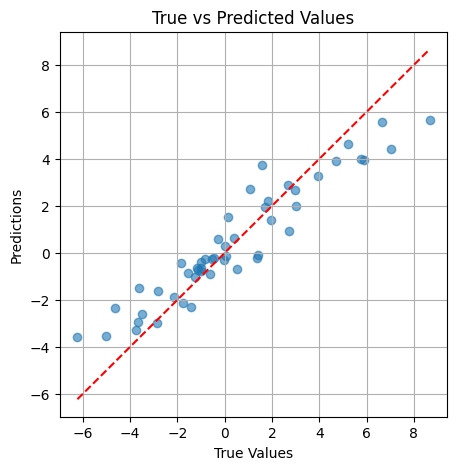

In [ ]:
def generate_regression_data(n_samples=50, n_features=10, noise_std=1.0):
    np.random.seed(0)
    X = np.random.randn(n_samples, n_features)
    true_weights = np.random.randn(n_features, 1)
    y = X @ true_weights + np.random.normal(0, noise_std, (n_samples, 1))
    return X, y

X_reg, y_reg = generate_regression_data(noise_std=1.0)

model = MyMLP(
    layer_sizes=[10, 20, 1],
    task='regression',
    activations=['relu', 'linear'],
    epochs=400,
    learning_rate=1e-2,
    reg_type='l1l2',
    lambda1=0.35,
    lambda2=0.3,
    verbose=False
)
model.train(X_reg, y_reg)

# Предсказания
preds = model.predict(X_reg)

# Визуализация
plt.figure(figsize=(5, 5))
plt.scatter(y_reg, preds, alpha=0.6)
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.grid(True)
plt.show()

# Классификация MyMLP (Мультиклассовая)

Accuracy on test set: 0.9333


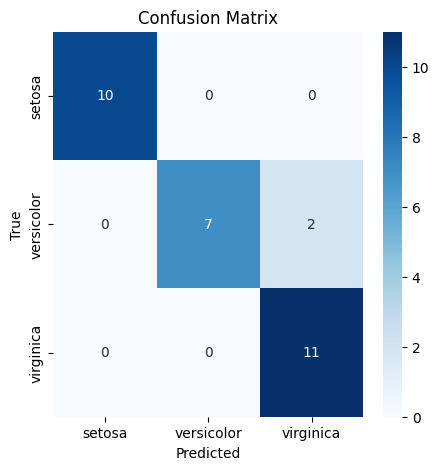

In [ ]:
# iris
data = load_iris()
X = data.data  # (150, 4)
y = data.target  # метки классов 0,1,2
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = MyMLP(
    layer_sizes=[4, 32, 3],
    activations=['relu', 'softmax'],
    task='multiclass_classification',
    learning_rate=1e-3,
    epochs=500,
    verbose=False,
    batch_size=None,
    reg_type=None,
    lambda1=0.2,
    lambda2=0.1
)

model.train(X_train, y_train)

preds = model.predict(X_test)
accuracy = np.mean(preds == y_test)
print(f"Accuracy on test set: {accuracy:.4f}")
preds = model.predict(X_test)
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names,
            yticklabels=data.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()